# Higher-order interaction test

In [1]:
%load_ext autoreload
%autoreload 2
from creme import creme
from creme import utils
from creme import custom_model
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import shuffle

2024-06-10 15:32:45.740168: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Load Enformer and example sequences

In [2]:
data_dir = '../../../data'
track_index = [5111]
# TSS bin indeces
bins = [447, 448]
model = custom_model.Enformer(track_index=track_index, bin_index=bins)

2024-06-10 15:32:47.349063: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-10 15:32:48.819795: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 67919 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:85:00.0, compute capability: 8.0


In [3]:
fasta_path = f'{data_dir}/GRCh38.primary_assembly.genome.fa'
seq_parser = utils.SequenceParser(fasta_path)

gene = 'CLUAP1_chr16_3501011_+'

gene_name, chrom, start, strand = gene.split('_')
wt_seq = seq_parser.extract_seq_centered(chrom, int(start), strand, model.seq_length)
wt = model.predict(wt_seq)[0,:,0].mean()

2024-06-10 15:32:53.943122: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-06-10 15:32:54.196676: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401


**Higher-order interaction test**


In this example we will comprehensively analyze the context of the GATA2 gene using a greedy search for necessary tiles.

To run the test we need:
- a loaded model
- a list of tile coordinates to test
- optimization - choice between [np.argmin, np.argmax] which determines if we will search for enhancers or silencers
- num_shuffle - number of shuffled
- number of iterations or tiles to shuffle


In [4]:

perturb_window = 5000
N_shuffles = 10
tss_tile, cre_tiles = utils.set_tile_range(model.seq_length, perturb_window)


In [5]:
len(cre_tiles)

38

CLUAP1 gene context

In [6]:
result_summary = creme.higher_order_interaction_test(model, wt_seq, cre_tiles.copy(),
                                                  np.argmin, num_shuffle=5, num_rounds=3)

100%|████████████████████████████████████████████████████████████████████████████| 3/3 [05:50<00:00, 116.67s/it]


Result breakdown

During the first iteration, we start with the WT sequence. The initial prediction is the same as WT.  

In [7]:
result_summary[0]['initial_pred'] == wt.mean()

True

In the first iteration all the tiles are shuffled producing 38 prediction values. The lowest TSS activity value will be selected in this iteration and saved as selected_mean_pred - in this case the point circled in black in panel 1. After this the tile is kept shuffled and iteration 2 starts with the remaining 37 tiles. In each iteration 1 tile is elminated and the plots show the selected tile in each case - the shuffling of which yields the lowest TSS activity.

Number of Tiles shuffled in iteration 1: 38
Number of Tiles shuffled in iteration 2: 37
Number of Tiles shuffled in iteration 3: 36


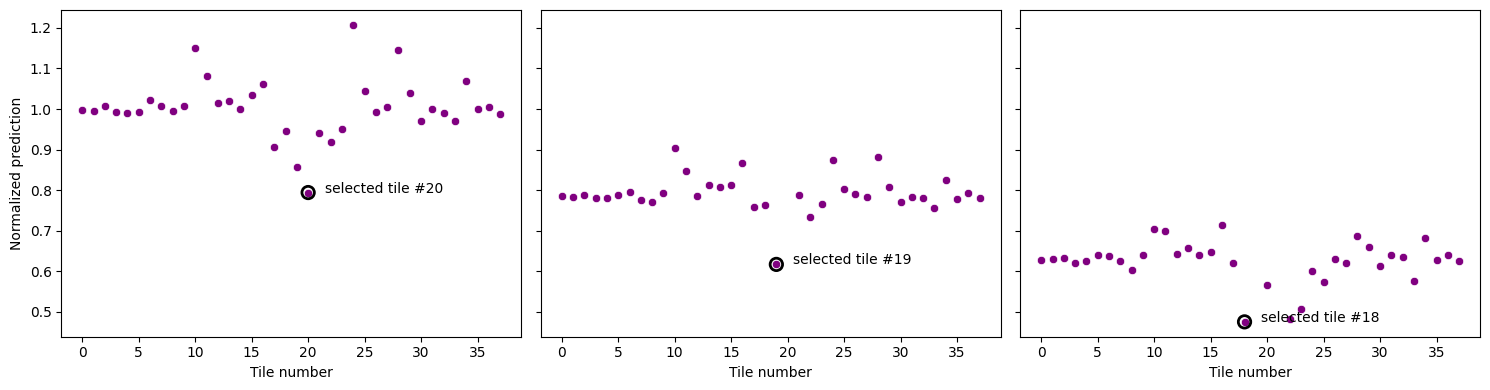

In [8]:
fig, axes = plt.subplots(1, len(result_summary.keys()), figsize=[15, 4], sharey=True)
shuffled_tiles = []
for i in result_summary.keys():
    ax = axes[i]
    print(f'Number of Tiles shuffled in iteration {i+1}: {result_summary[i]["preds"].shape[0]}')
    mean_preds = result_summary[i]['preds'].mean(axis=-1).copy()
    for s in shuffled_tiles:
        mean_preds = np.insert(mean_preds, s, np.nan)
    min_i = np.nanargmin(mean_preds)
    shuffled_tiles.append(min_i)
    
    sns.scatterplot(x=range(38), y=mean_preds/wt, color='purple', ax=ax)
    ax.set_xlabel('Tile number')
    axes[0].set_ylabel('Normalized prediction')
    assert np.min(result_summary[i]['preds'].mean(axis=-1)) == result_summary[i]['selected_mean_pred']
    sns.scatterplot(x=[min_i], y=[mean_preds[min_i]/wt], s=80, facecolors='none', edgecolors='k', linewidth=2, ax=ax)
    ax.annotate(f'selected tile #{min_i}', [min_i+1.5, mean_preds[min_i]/wt]);
plt.tight_layout()

Now let's re-create the sequences in each iteration by following the tile order in 'selected tile' to shuffle putative CRE tiles, then obtain predictions and plot those versus the WT.

In [9]:
model.bin_index = None # switch to saving all track not just TSS bins
wt_track = model.predict(wt_seq)[0,:,0]

In [10]:

shuffled_tile_seq = wt_seq.copy()
per_iteration_preds = []
for i in result_summary.keys():
    preds = []
    tile_start, tile_end = result_summary[i]['selected_tile']
    #shuffle this
    for j in range(10): # number of shuffles
        background_seq = shuffle.dinuc_shuffle(wt_seq)
        shuffled_tile_seq[tile_start: tile_end] = background_seq[tile_start: tile_end]
        preds.append(model.predict(shuffled_tile_seq)[0,:,0])
    per_iteration_preds.append(preds)

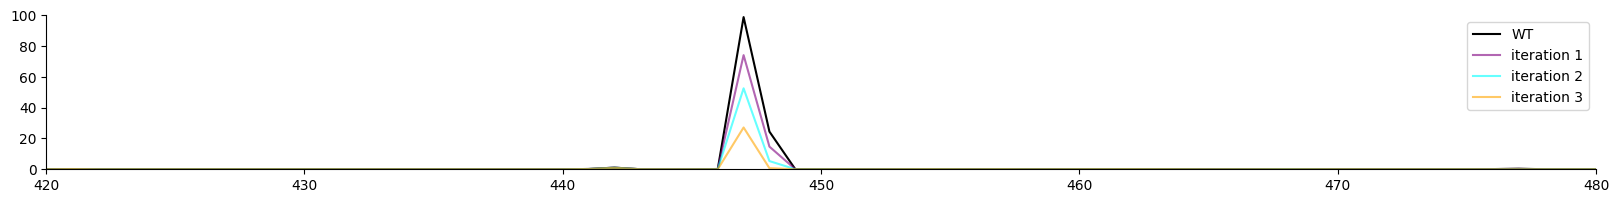

In [11]:
ax=utils.plot_track([wt_track], label='WT', color='k', alpha=1)
colors = ['purple', 'cyan', 'orange']
for i, preds in enumerate(per_iteration_preds):
    
    utils.plot_track([np.array(preds).mean(axis=0)], zoom=[420, 480], label=f'iteration {i+1}', ax=ax, color=colors[i])
ax.set_ylim(0,100)
plt.legend();